# Final Project | recovery-news-data.csv

*CS 334 - Algorithms of Machine Learning | Conrad Kennington*

*Computer Science | Boise State University*

*12.05.2022 | Fall 2022*

*Aida Gomezbueno Berezo | aidagomezbuenobe@u.boisestate.edu*

In [35]:
%matplotlib inline

import datetime
import math
import nltk
import numpy as np
import num2words
import pandas as pd
import time
from datetime import datetime
import matplotlib.pyplot as plt
from nltk.stem import *
from nltk.corpus import names, stopwords, words
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.naive_bayes import GaussianNB

from scipy import sparse

import warnings
warnings.filterwarnings("ignore")

In [36]:
dat = pd.read_csv(r'recovery-news-data.csv')
df = pd.DataFrame(dat)
df.columns = ['index', 'news_id', 'url', 'publisher', 'publish_date', 'author', 'title', 'image', 'body_text', 'political_bias', 'country', 'reliability']
df = df.drop('index', axis=1)
df.head()

,news_id,url,publisher,publish_date,author,title,image,body_text,political_bias,country,reliability
0,0,https://www.nytimes.com/article/what-is-corona...,The New York Times,2020-01-21,"['Knvul Sheikh', 'Roni Caryn Rabin']",The Coronavirus: What Scientists Have Learned ...,https://static01.nyt.com/images/2020/03/12/sci...,\nA novel respiratory virus that originated in...,Left,USA,1
1,1,https://www.npr.org/2020/01/22/798392172/chine...,National Public Radio (NPR),2020-01-22,['Emily Feng'],Chinese Health Officials: More Die From Newly ...,https://media.npr.org/include/images/facebook-...,Chinese Health Officials: More Die From Newly ...,Center,USA,1
2,2,https://www.theverge.com/2020/1/23/21078457/co...,The Verge,2020-01-23,['Nicole Wetsman'],Everything you need to know about the coronavirus,https://cdn.vox-cdn.com/thumbor/a9_Oz7cvSBKyal...,Public health experts around the globe are scr...,Left-center,USA,1
3,3,https://www.worldhealth.net/news/novel-coronav...,WorldHealth.Net,2020-01-24,[],Novel Coronavirus Cases Confirmed To Be Spreading,https://www.worldhealth.net/media/original_ima...,The first two coronavirus cases in Europe have...,NaN,USA,0
4,4,https://www.theverge.com/2020/1/24/21080845/co...,The Verge,2020-01-24,"['Nicole Wetsman', 'Zoe Schiffer', 'Jay Peters...",Coronavirus disrupts the world: updates on the...,https://cdn.vox-cdn.com/thumbor/t2gt1SmEni4Mcr...,"A new coronavirus appeared in Wuhan, China, at...",Left-center,USA,1


## Dataset description | Context

In [37]:
unique_vals = pd.unique(df['publisher'])
n_val = df['publisher'].nunique()
n_publishers = unique_vals.size

news_dict = {}
temp = 0
glob_count = 0
for x in range(n_publishers):
    n=0
    temp = unique_vals[x]
    for y in range(df['publisher'].size):
        temp2 = str(df['publisher'].values[y])
        if temp==temp2:
            n+=1
    news_dict[temp] = n
    glob_count+=n

for i in news_dict:
    print("Publisher: ", i, " -> ", news_dict.get(i), "news.")

print("\nNumber of publishers: ", n_publishers)
#print("\nNumber of publishers: ", n_val)

print("\nTotal news: ", glob_count)

Publisher:  The New York Times  ->  67 news.
Publisher:  National Public Radio (NPR)  ->  92 news.
Publisher:  The Verge  ->  139 news.
Publisher:  WorldHealth.Net  ->  75 news.
Publisher:  Chicago Sun-Times  ->  322 news.
Publisher:  Health Impact News  ->  19 news.
Publisher:  Heartland Institute  ->  30 news.
Publisher:  Activist Post  ->  20 news.
Publisher:  The Atlantic  ->  13 news.
Publisher:  Washington Monthly  ->  6 news.
Publisher:  Sputnik News  ->  144 news.
Publisher:  The Mercury News  ->  17 news.
Publisher:  USA Today  ->  118 news.
Publisher:  Politico  ->  66 news.
Publisher:  The Detroit News  ->  31 news.
Publisher:  The Washington Post  ->  33 news.
Publisher:  Los Angeles Daily News  ->  20 news.
Publisher:  Pravda Report  ->  27 news.
Publisher:  CBS News  ->  67 news.
Publisher:  Natural News  ->  23 news.
Publisher:  RealFarmacy  ->  2 news.
Publisher:  PBS NewsHour  ->  10 news.
Publisher:  CNBC  ->  46 news.
Publisher:  Health Nut News  ->  10 news.
Publish

In [38]:
r_news_dict={}

for x in range(n_publishers):
    n=0
    temp = unique_vals[x]
    for y in range(df['publisher'].size):
        temp2 = str(df['publisher'].values[y])
        if temp==temp2:
            rel = df['reliability'].values[y]
            if(rel==1): #Real new
                n+=1
    r_news_dict[temp] = n

n_reliable_publishers=0
for i in r_news_dict:
    print("Publisher: ", i, " -> ", (r_news_dict.get(i)/news_dict.get(i))*100, " % reliability -", r_news_dict.get(i), " real news.")
    r = int(r_news_dict.get(i))
    if r!=0:
        n_reliable_publishers+=1
n_non_reliable=n_publishers-n_reliable_publishers
print("\nNumber of reliable publishers: ", n_reliable_publishers, ". ", ((n_reliable_publishers/n_publishers)*100), "% over the total.")
print("Therefore, number of unreliable publishers: ", n_non_reliable, ".", ((n_non_reliable/n_publishers)*100), "% over the total.")


Publisher:  The New York Times  ->  100.0  % reliability - 67  real news.
Publisher:  National Public Radio (NPR)  ->  100.0  % reliability - 92  real news.
Publisher:  The Verge  ->  100.0  % reliability - 139  real news.
Publisher:  WorldHealth.Net  ->  0.0  % reliability - 0  real news.
Publisher:  Chicago Sun-Times  ->  100.0  % reliability - 322  real news.
Publisher:  Health Impact News  ->  0.0  % reliability - 0  real news.
Publisher:  Heartland Institute  ->  0.0  % reliability - 0  real news.
Publisher:  Activist Post  ->  0.0  % reliability - 0  real news.
Publisher:  The Atlantic  ->  100.0  % reliability - 13  real news.
Publisher:  Washington Monthly  ->  100.0  % reliability - 6  real news.
Publisher:  Sputnik News  ->  0.0  % reliability - 0  real news.
Publisher:  The Mercury News  ->  100.0  % reliability - 17  real news.
Publisher:  USA Today  ->  100.0  % reliability - 118  real news.
Publisher:  Politico  ->  100.0  % reliability - 66  real news.
Publisher:  The De

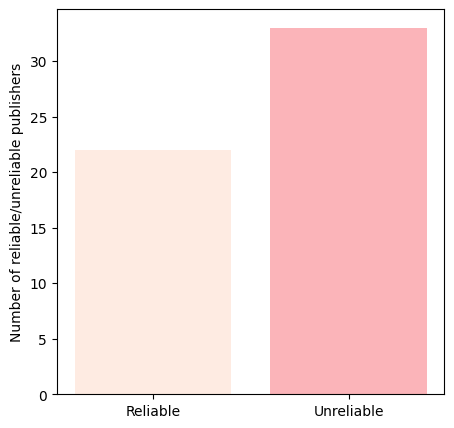

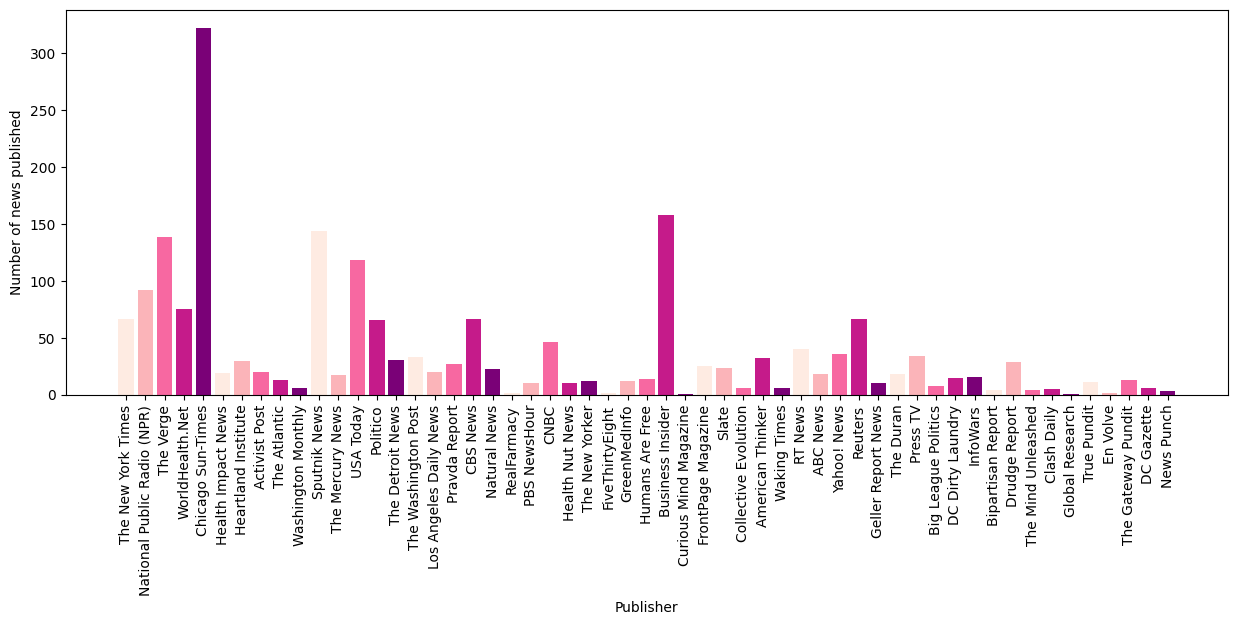

In [39]:
#DataFrame statistics
df_stat = pd.DataFrame()
df_stat['Publisher'] = news_dict.keys()
df_stat['Number_of_news'] = news_dict.values()
df_stat['Reliable'] = r_news_dict.values()
df_stat['Reliable'] = df_stat['Reliable'].where(df_stat['Reliable'].astype(int)==0, 1)
df_stat_dict = {}
df_stat_dict['Reliable'] = n_reliable_publishers
df_stat_dict['Unreliable'] = n_non_reliable
#df_stat_dict

colors = ['#feebe2', '#fbb4b9', '#f768a1', '#c51b8a', '#7a0177']

fig, ax = plt.subplots(figsize=(5, 5))

plt.bar(df_stat_dict.keys(), df_stat_dict.values(), color=colors)
plt.ylabel("Number of reliable/unreliable publishers")
plt.show()

fig, ax = plt.subplots(figsize=(15, 5))

plt.bar(df_stat['Publisher'], df_stat['Number_of_news'], color=colors)
plt.xlabel("Publisher")
plt.ylabel("Number of news published")
plt.xticks(rotation=90)
plt.show()

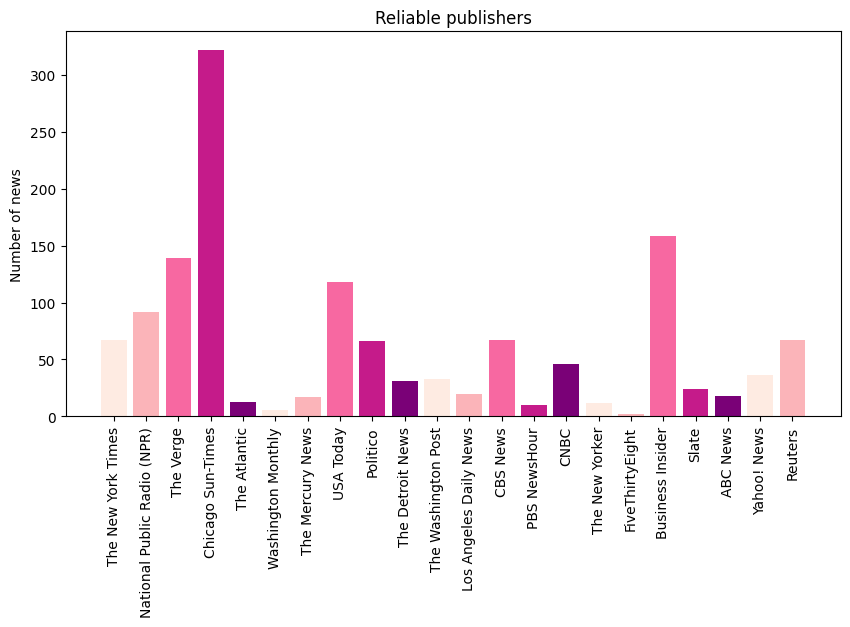

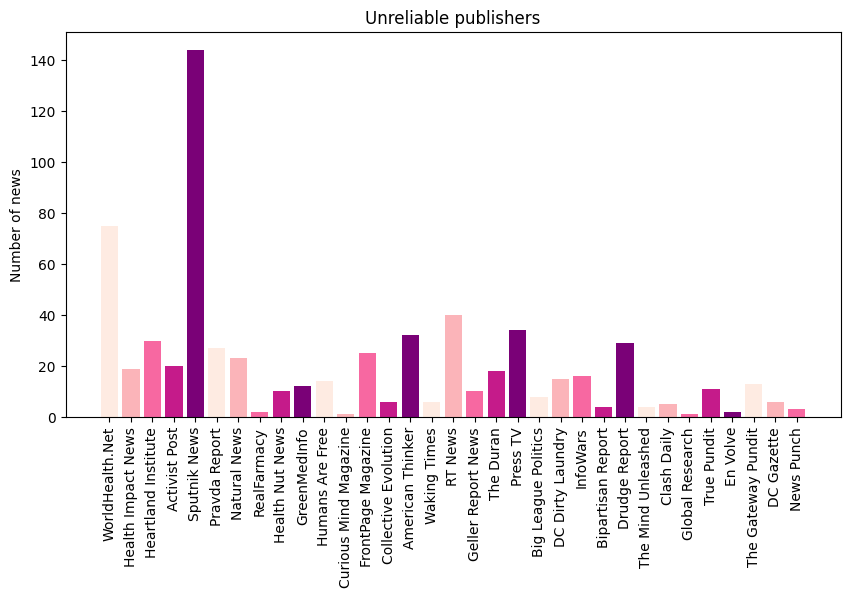

In [40]:
#REL VS NONREL
rel = []
rel_news = []
non_rel = []
non_rel_news = []
for x in range(df_stat['Publisher'].size):
    if df_stat['Reliable'].iloc[x] == 1:
        rel.append(df_stat['Publisher'].iloc[x])
        rel_news.append(df_stat['Number_of_news'].iloc[x])
    else:
        non_rel.append(df_stat['Publisher'].iloc[x])
        non_rel_news.append(df_stat['Number_of_news'].iloc[x])
df_rels = pd.DataFrame()
df_rels['Publisher'] = rel
df_rels['Number_of_news'] = rel_news
df_non_rels = pd.DataFrame()
df_non_rels['Publisher'] = non_rel
df_non_rels['Number_of_news'] = non_rel_news

fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(df_rels['Publisher'], df_rels['Number_of_news'], color=colors)
plt.title("Reliable publishers")
plt.ylabel("Number of news")
plt.xticks(rotation=90)
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(df_non_rels['Publisher'], df_non_rels['Number_of_news'], color=colors)
plt.title("Unreliable publishers")
plt.ylabel("Number of news")
plt.xticks(rotation=90)
plt.show()

In [41]:
#FEATURE: AUTHOR
df['author'] = df['author'].fillna("0")
author_dict = {}
n=1
unique_vals = pd.unique(df['author'])
#Maybe would be more accurate if rather than considering having sets of authors repeatedly, split them in several columns or whatever
uniq = []
for i in unique_vals:
    i = str(i)
    i = i.replace("[", "")
    i = i.replace("]", "")
    i = i.replace("'", "")
    splited = i.split(", ")
    for j in splited:
        uniq.append(j)
unique_vals = pd.unique(uniq)
n_authors = len(unique_vals)

authors_news = {}
authors_col_dict = {}
authors_rel_news = {}
for x in range(n_authors):
    n=0
    news=[]
    rel=[]
    temp = unique_vals[x]
    for y in range(df['author'].size):
        temp2 = str(df['author'].values[y])
        temp2 = temp2.replace("[", "")
        temp2 = temp2.replace("]", "")
        temp2 = temp2.replace("'", "")
        if temp in temp2:
            n+=1
            news.append(df['news_id'].iloc[y])
            rel.append(df['reliability'].iloc[y])
    authors_col_dict[temp] = n
    authors_news[temp] = news 
    authors_rel_news[temp] = rel
    
len(authors_col_dict)
del authors_col_dict['']
del authors_col_dict['0']
del authors_news['']
del authors_news['0']
del authors_rel_news['']
del authors_rel_news['0']

df_author = pd.DataFrame()
df_author['Author'] = authors_col_dict.keys()
df_author['Contributions'] = authors_col_dict.values()
df_author['Related_news'] = authors_news.values()
df_author['Overall_reliability'] = authors_rel_news.values()

n_authors = len(authors_col_dict)
#authors_col_dict
print("Number of authors contributing: ", n_authors)

max_contr = df_author.loc[df_author['Contributions'].idxmax()]
print("The author involved in max num of articles/news is: ", max_contr[0], "\n\tNumber of news: ", max_contr[1], "\n\tNews ID in which the author is involved: ", max_contr[2])

min_contr = df_author.loc[df_author['Contributions'].idxmin()]
print("The author involved in min num of articles/news is: ", min_contr[0], "\n\tNumber of news: ", min_contr[1], "\n\tNews ID in which the author is involved: ", min_contr[2])

df_author

Number of authors contributing:  1095
The author involved in max num of articles/news is:  Dan 
	Number of news:  48 
	News ID in which the author is involved:  [80, 81, 111, 114, 115, 140, 154, 158, 161, 188, 217, 288, 345, 348, 545, 627, 637, 688, 740, 845, 903, 913, 928, 1027, 1104, 1116, 1133, 1135, 1253, 1270, 1336, 1386, 1387, 1391, 1406, 1527, 1550, 1571, 1586, 1591, 1618, 1619, 1627, 1632, 1686, 1729, 1772, 1872]
The author involved in min num of articles/news is:  Roni Caryn Rabin 
	Number of news:  1 
	News ID in which the author is involved:  [0]


,Author,Contributions,Related_news,Overall_reliability
0,Knvul Sheikh,2,"[0, 1599]","[1, 1]"
1,Roni Caryn Rabin,1,[0],[1]
2,Emily Feng,3,"[1, 768, 887]","[1, 1, 1]"
3,Nicole Wetsman,12,"[2, 4, 342, 384, 387, 390, 430, 518, 541, 659,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
4,Zoe Schiffer,3,"[4, 134, 866]","[1, 1, 1]"
...,...,...,...,...
1090,Noah Bierman,1,[2024],[0]
1091,Hannah Fry,1,[2024],[0]
1092,Tom Kludt,1,[2025],[0]
1093,Jonathan Lai,1,[2026],[0]


In [42]:
subdf_authors = pd.DataFrame()
authors = [df_author.loc[df_author['Author']=='Dan'].iloc[0,0], df_author.loc[df_author['Author']=='Gary'].iloc[0,0], df_author.loc[df_author['Author']=='Mohamed'].iloc[0,0], df_author.loc[df_author['Author']=='Greg'].iloc[0,0]]
contributions = [df_author.loc[df_author['Author']=='Dan'].iloc[0,1], df_author.loc[df_author['Author']=='Gary'].iloc[0,1], df_author.loc[df_author['Author']=='Mohamed'].iloc[0,1], df_author.loc[df_author['Author']=='Greg'].iloc[0,1]]
related_news = [df_author.loc[df_author['Author']=='Dan'].iloc[0,2], df_author.loc[df_author['Author']=='Gary'].iloc[0,2], df_author.loc[df_author['Author']=='Mohamed'].iloc[0,2], df_author.loc[df_author['Author']=='Greg'].iloc[0,2]]
overall_rel = [df_author.loc[df_author['Author']=='Dan'].iloc[0,3], df_author.loc[df_author['Author']=='Gary'].iloc[0,3], df_author.loc[df_author['Author']=='Mohamed'].iloc[0,3], df_author.loc[df_author['Author']=='Greg'].iloc[0,3]]
subdf_authors['Author']=authors
subdf_authors['Contributions']=contributions
subdf_authors['Related_news']=related_news
subdf_authors['Overall_reliability']=overall_rel

unconsistent_authors_dict = {}
for i in authors_rel_news:
    n=0
    temp = authors_rel_news.get(i)[0]
    for j in authors_rel_news.get(i):
        if j!= temp:
            n+=1
    if(n!=0): 
        unconsistent_authors_dict[i]=n
rel_index_dict={}
for x in range(subdf_authors['Overall_reliability'].size):
    n = len(subdf_authors.iloc[x, 3])
    count = 0
    for i in subdf_authors.iloc[x, 3]:
        if i==1:
            count+=1
    count/=n
    rel_index_dict[subdf_authors.iloc[x, 0]] = count
    
subdf_authors['Index_reliability']=rel_index_dict.values()

subdf_authors

,Author,Contributions,Related_news,Overall_reliability,Index_reliability
0,Dan,48,"[80, 81, 111, 114, 115, 140, 154, 158, 161, 18...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...",0.437500
1,Gary,2,"[55, 1364]","[0, 1]",0.500000
2,Mohamed,6,"[802, 917, 1066, 1136, 1546, 1669]","[0, 0, 1, 0, 0, 0]",0.166667
3,Greg,8,"[249, 1101, 1199, 1292, 1665, 1746, 1841, 2004]","[1, 1, 1, 1, 0, 0, 0, 0]",0.500000


Country:  USA  ->  1662 news.
Country:  Russia  ->  211 news.
Country:  UK  ->  67 news.
Country:  Cyprus  ->  18 news.
Country:  Iran  ->  34 news.
Country:  Canada  ->  1 news.

Number of countries:  6


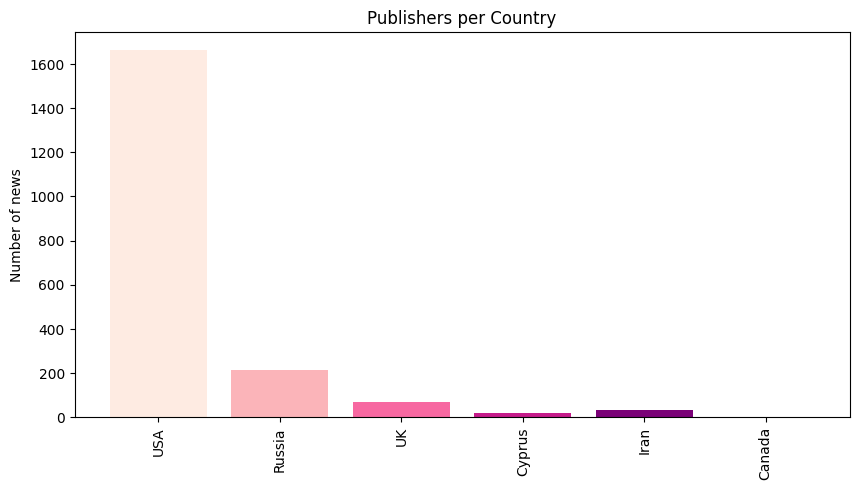

In [43]:
unique_vals = pd.unique(df['country'].dropna())
n_countries = unique_vals.size
count_dict = {}
temp = 0

for x in range(n_countries):
    n=0
    temp = unique_vals[x]
    for y in range(df['country'].size):
        temp2 = str(df['country'].values[y])
        if temp==temp2:
            n+=1
    count_dict[temp] = n
    
df_countries = pd.DataFrame()
df_countries['Country'] = count_dict.keys()
df_countries['Contributions'] = count_dict.values()

for i in count_dict:
    print("Country: ", i, " -> ", count_dict.get(i), "news.")
print("\nNumber of countries: ", n_countries)

colors = ['#feebe2', '#fbb4b9', '#f768a1', '#c51b8a', '#7a0177']

fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(df_countries['Country'], df_countries['Contributions'], color=colors)
plt.title("Publishers per Country")
plt.ylabel("Number of news")
plt.xticks(rotation=90)
plt.show()

## Cleaning + Combining features

In [44]:
clean_subs = ['https://', 'http://', 'www.']
substring = "/"
urls=[]
for i in df['url']:
    for j in clean_subs:
        if j in i:
            i = i.split(j)
            i = i[1]
    if substring in i:
        i = i.split(substring)
        i = i[0]
    urls.append(i)
df['url']=urls

df['publish_date'] = df['publish_date'].fillna("1970-11-01")
epoch = datetime.utcfromtimestamp(0)
for i in df['publish_date']:
    date_object = datetime.strptime(str(i), '%Y-%m-%d').date()
    delta = date_object - epoch.date()
    dt = datetime.fromtimestamp(int(delta.total_seconds())).strftime('%Y-%m-%d')
    mth = datetime.fromtimestamp(int(delta.total_seconds())).strftime('%B')
    if mth=="October":
        mth = "UNKNOWN"
    df['publish_date'] = df['publish_date'].replace(i, mth)
df['author'] = df['author'].fillna("")
replace_simb = ['[', ']', "'", ' etc.', "‘"]
coma = ", "
array_col = []
for i in df['author']:
    temp = []
    for j in replace_simb:
        if j in i:
            i = i.replace(j, "")
            
df['political_bias'] = df['political_bias'].fillna("NEUTRAL")
df['image'] = df['image'].fillna("")
df['title'] = df['title'].fillna("")
df['country'] = df['country'].fillna("UNKNOWN")

df['alltext'] = df['publisher'] + " " + df['author'] + " " +df['political_bias'] + " " + df['title'] + " " + df['body_text'] 

In [45]:
df.head()

,news_id,url,publisher,publish_date,author,title,image,body_text,political_bias,country,reliability,alltext
0,0,nytimes.com,The New York Times,January,"['Knvul Sheikh', 'Roni Caryn Rabin']",The Coronavirus: What Scientists Have Learned ...,https://static01.nyt.com/images/2020/03/12/sci...,\nA novel respiratory virus that originated in...,Left,USA,1,"The New York Times ['Knvul Sheikh', 'Roni Cary..."
1,1,npr.org,National Public Radio (NPR),January,['Emily Feng'],Chinese Health Officials: More Die From Newly ...,https://media.npr.org/include/images/facebook-...,Chinese Health Officials: More Die From Newly ...,Center,USA,1,National Public Radio (NPR) ['Emily Feng'] Cen...
2,2,theverge.com,The Verge,January,['Nicole Wetsman'],Everything you need to know about the coronavirus,https://cdn.vox-cdn.com/thumbor/a9_Oz7cvSBKyal...,Public health experts around the globe are scr...,Left-center,USA,1,The Verge ['Nicole Wetsman'] Left-center Every...
3,3,worldhealth.net,WorldHealth.Net,January,[],Novel Coronavirus Cases Confirmed To Be Spreading,https://www.worldhealth.net/media/original_ima...,The first two coronavirus cases in Europe have...,NEUTRAL,USA,0,WorldHealth.Net [] NEUTRAL Novel Coronavirus C...
4,4,theverge.com,The Verge,January,"['Nicole Wetsman', 'Zoe Schiffer', 'Jay Peters...",Coronavirus disrupts the world: updates on the...,https://cdn.vox-cdn.com/thumbor/t2gt1SmEni4Mcr...,"A new coronavirus appeared in Wuhan, China, at...",Left-center,USA,1,"The Verge ['Nicole Wetsman', 'Zoe Schiffer', '..."


## Preprocessing | Basic Steps

    1. Lowercase. 
    2. Stop words.
    3. Punctuation/Symbols.
    4. Apostophre.
    5. Single characters.
    6. Stemming.
    7. Lemmatisation.
    8. Converting Numbers.

In [46]:
def toLowerCase(df):
    df['alltext'] = df['alltext'].str.lower()
    return df

def delStopWords(df):
    stop_words = nltk.corpus.stopwords.words('english')
    valid_allt=[]
    for i in df['alltext']:
        valid_t=[]
        for j in i:
            if j not in stop_words:
                valid_t.append(j)
        valid_allt.append(valid_t)
    df['alltext']=valid_allt
    return df

def toListOfLists(df):
    all_text = []
    for i in df['alltext']:
        i = i.split()
        all_text.append(i)
    df['alltext']=all_text
    return df  

def delSymbols(df):
    symbols = "!\"“‘’”#$%&()*+-./:;<,=>?@[\]^_`{|}~\n►●…"
    valid_allt=[]
    for i in df['alltext']:
        valid_t = []
        for j in i:
            for k in symbols:
                if k in j:
                    j = j.replace(k, "")
            valid_t.append(j)
        if "[]" in valid_t:
            valid_t.remove("[]")
        valid_allt.append(valid_t)
    df['alltext']=valid_allt
    return df

def delApostrophe(df):
    stop_words = nltk.corpus.stopwords.words('english')
    valid_alltext=[]
    for i in df['alltext']:
        valid_text=[]
        for j in i:
            if j not in stop_words:
                if "'" in j:
                    j=j.replace("'", "")
                valid_text.append(j)
        valid_alltext.append(valid_text)
    df['alltext']=valid_alltext
    return df

def delSingleChars(df):
    valid_allt=[]
    for i in df['alltext']:
        valid_t = []
        for j in i:
            if len(j)>1:
                valid_t.append(j)
        valid_allt.append(valid_t)
    df['alltext']=valid_allt
    return df

#NOMBRES PROPIOS CON PUNTOS.
def remainDomains(df):
    domain_dot=[]
    for i in df['publisher']:
        if "." in i:
            domain_dot.append(str(i).lower())
    domain_dot = np.unique(domain_dot)
    valid_allt=[]
    for i in df['alltext']:
        valid_t=[]
        for j in i:
            for k in domain_dot:
                if "." in k:
                    k_wodot = k.replace(".", "")
                    if k_wodot in j:
                        j = j.replace(j, k)
            valid_t.append(j)
        valid_allt.append(valid_t)
    df['alltext']=valid_allt    
    return df

#THE ORDER IS LEMMATIZATION THEN STEMMING, OR JUST STEMMING.
def lemmatize(df):
    wnl = WordNetLemmatizer()
    valid_allt=[]
    for i in df['alltext']:
        valid_t=[]
        for j in i:
            j = wnl.lemmatize(j)
            valid_t.append(j)
        valid_allt.append(valid_t) 
    df['alltext']=valid_allt
    return df

#STEMMING
def stem(df):
    stemmer = PorterStemmer()
    valid_allt=[]
    for i in df['alltext']:
        valid_t=[]
        for j in i:
            j = stemmer.stem(j)
            valid_t.append(j)
        valid_allt.append(valid_t) 
    df['alltext']=valid_allt
    return df
    #df.to_csv('preprocessing-numbers.csv', index=False)
    
#converting numbers
def num_conversion(j):
    k, l = j.split()
    k = float(k)
    l = float(l)
    j = str(k*l)
    return j

def convertNumbers(df):
    valid_allt=[]
    for i in df['alltext']:
        valid_t = []
        for j in i:
            if j.isnumeric():
                if "½" in j:
                    j = j.replace("½", " 0.5")
                    j = num_conversion(j)
                if "¼" in j:
                    j = j.replace("¼", " 0.25")
                    j = num_conversion(j)
                if "⅔" in j:
                    j = j.replace("⅔", " 0.67")
                    j = num_conversion(j)
                if "¾" in j:
                    j = j.replace("¾", " 0.75")
                    j = num_conversion(j)
                if "⅓" in j:
                    j = j.replace("⅓", " 0.33")
                    j = num_conversion(j)
                j = num2words.num2words(float(j))
            valid_t.append(j)          
        valid_allt.append(valid_t)
    df['alltext']=valid_allt
    return df
    #df.to_csv('preprocessing-no_numbers.csv', index=False)

def preprocess(df):
    df = toLowerCase(df)
    df = toListOfLists(df)
    df = delStopWords(df)
    df = delSymbols(df)
    df = delStopWords(df)
    df = delApostrophe(df)
    df = delSingleChars(df)
    df = lemmatize(df)
    df = stem(df)
    df = convertNumbers(df)
    df = delSymbols(df)
    df = remainDomains(df)

In [47]:
preprocess(df)
df.head()

,news_id,url,publisher,publish_date,author,title,image,body_text,political_bias,country,reliability,alltext
0,0,nytimes.com,The New York Times,January,"['Knvul Sheikh', 'Roni Caryn Rabin']",The Coronavirus: What Scientists Have Learned ...,https://static01.nyt.com/images/2020/03/12/sci...,\nA novel respiratory virus that originated in...,Left,USA,1,"[new, york, time, knvul, sheikh, roni, caryn, ..."
1,1,npr.org,National Public Radio (NPR),January,['Emily Feng'],Chinese Health Officials: More Die From Newly ...,https://media.npr.org/include/images/facebook-...,Chinese Health Officials: More Die From Newly ...,Center,USA,1,"[nation, public, radio, npr, emili, feng, cent..."
2,2,theverge.com,The Verge,January,['Nicole Wetsman'],Everything you need to know about the coronavirus,https://cdn.vox-cdn.com/thumbor/a9_Oz7cvSBKyal...,Public health experts around the globe are scr...,Left-center,USA,1,"[verg, nicol, wetsman, leftcent, everyth, need..."
3,3,worldhealth.net,WorldHealth.Net,January,[],Novel Coronavirus Cases Confirmed To Be Spreading,https://www.worldhealth.net/media/original_ima...,The first two coronavirus cases in Europe have...,NEUTRAL,USA,0,"[worldhealth.net, neutral, novel, coronaviru, ..."
4,4,theverge.com,The Verge,January,"['Nicole Wetsman', 'Zoe Schiffer', 'Jay Peters...",Coronavirus disrupts the world: updates on the...,https://cdn.vox-cdn.com/thumbor/t2gt1SmEni4Mcr...,"A new coronavirus appeared in Wuhan, China, at...",Left-center,USA,1,"[verg, nicol, wetsman, zoe, schiffer, jay, pet..."


## TF-IDF Score
> #### TF (Term Frequency). TF is individual to each document and word. Frequency of a term in relation to the doc that belongs to.
> * TF(t,d) = count of t in d.

> #### DF (Document Frequency). Number of documents in which the word is present.
> * DF(t) = occurrence of t in N documents.

> #### IDF (Inverse Document Frequency). Informativeness of term t.
> * IDF(t) = log(D/df).

> #### TF-IDF (Term Frequency - Inverse Document Frequency).
> * TF-IDF(t,d) = tf(t,d)*log(N/df).

In [48]:
def getTF(df):
    tf_all = []
    n_docs = len(df['alltext'])
    n_words_per_doc = {}
    w = 0
    for i in df['alltext']:
        term_freq = {} 
        uniq_vals = pd.unique(i) 
        n_words = len(i) 
        n_words_per_doc[w] = n_words 
        w+=1
        n_uniq_vals = len(uniq_vals)
        for x in range(n_uniq_vals): 
            n=0
            temp = uniq_vals[x]
            for j in i:
                if j==temp: 
                    n+=1
            term_freq[temp]=n 
        tf_all.append(term_freq) 
    return df, n_docs, tf_all
    
def getDF(df, n_docs, tf_all):    
    words_ = []
    n=0
    for x in range(n_docs): 
        dict_ = tf_all[x] 
        for y in dict_.keys(): 
            words_.append(y)
            n+=1
    words = np.unique(words_) 
    nw = len(words) 
    n_news = len(tf_all)
    doc_freq={}
    for x in range(nw):
        n=0
        temp = words[x]
        for y in range(n_news):
            dict_ = tf_all[y]
            vals = dict_.keys()
            if temp in vals:
                n+=1 
                continue
        doc_freq[temp] = n
    return df, doc_freq, nw, words

def getIDF(df, doc_freq):
    idf={}
    n_docs = len(df['alltext'])
    for x in doc_freq.keys(): 
        df_=doc_freq.get(x)
        idf_=math.log(n_docs/(df_), 2)
        idf[x]=idf_
    return df, idf

def _getTFIDF(df, tf_all, idf):
    tf_idf_allt = []
    for x in range(len(tf_all)): 
        tf_idf={}
        dict_tf_doc = tf_all[x]
        for y in dict_tf_doc.keys():
            tf_r = dict_tf_doc.get(y)
            idf_r = idf.get(y)
            tf_idf_ = tf_r*idf_r
            tf_idf[y]=tf_idf_
        tf_idf_allt.append(tf_idf) 
    df['tf-idf']=tf_idf_allt
    return df, tf_idf_allt

def getTFIDF(nw, words, tf_idf_allt):
    dict_words = {}
    for x in range(nw):
        tfidf_scores = []
        temp = words[x]
        for y in tf_idf_allt:
            if temp in y:
                tfidf_scores.append(y.get(temp))
            else:
                tfidf_scores.append(0)
        dict_words[temp] = tfidf_scores
    df_tfidf = pd.DataFrame()
    for i in dict_words.keys():
        df_tfidf[i] = dict_words.get(i) #array
    return df, df_tfidf, dict_words

def _TfidfVectorizer(df):
    df, n_docs, tf_all = getTF(df)
    df, doc_freq, nw, words = getDF(df, n_docs, tf_all)
    df, idf = getIDF(df, doc_freq)
    df, tf_idf_allt = _getTFIDF(df, tf_all, idf)
    df, df_tfidf, dict_words = getTFIDF(nw, words, tf_idf_allt)
    return df_tfidf, tf_idf_allt, idf, doc_freq, nw

## TfidfVectorizer w/ Sparse Matrix

*In order to be able to train the model with the previous TF-IDF I've computed, I should first convert the DataFrame into a **sparse matrix** (as sklearn does with its TfidfVectorizer). After that, I'll be able to train, test, and finally getting an accuracy higher than 90%.*

In [49]:
df_tfidf, tf_idf_allt, idf, doc_freq, nw =_TfidfVectorizer(df)
df_tfidf_as_sparse_matrix = sparse.csr_matrix(df_tfidf)

X = df_tfidf_as_sparse_matrix.toarray()
y = df['reliability']
        
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [50]:
df_tfidf_as_sparse_matrix
#df_tfidf

<2029x39065 sparse matrix of type '<class 'numpy.float64'>'
	with 576077 stored elements in Compressed Sparse Row format>

In [51]:
clf = LogisticRegression(random_state = 0)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print("Accuracy: %.2f%%" % (accuracy_score(pred, y_test)*100))

Accuracy: 90.31%


## 5 - Fold Cross - Validation

In [52]:
def cross_validation(model, _X, _y, _cv=5):
      '''Function to perform 5 Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      _cv: int, default=5
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.
      '''
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy" : results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean()*100,
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean()*100,
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean()*100,
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean()*100,
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean()*100,
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()*100
              }

In [53]:
cross_validation(clf, X, y, 5)

{'Training Accuracy scores': array([1., 1., 1., 1., 1.]),
 'Mean Training Accuracy': 100.0,
 'Training Precision scores': array([1., 1., 1., 1., 1.]),
 'Mean Training Precision': 100.0,
 'Training Recall scores': array([1., 1., 1., 1., 1.]),
 'Mean Training Recall': 100.0,
 'Training F1 scores': array([1., 1., 1., 1., 1.]),
 'Mean Training F1 Score': 100.0,
 'Validation Accuracy scores': array([0.86453202, 0.9137931 , 0.90147783, 0.91133005, 0.87160494]),
 'Mean Validation Accuracy': 89.25475886395427,
 'Validation Precision scores': array([0.85620915, 0.89932886, 0.91756272, 0.91578947, 0.91984733]),
 'Mean Validation Precision': 90.17475070660043,
 'Validation Recall scores': array([0.95970696, 0.98168498, 0.93772894, 0.95604396, 0.88602941]),
 'Mean Validation Recall': 94.42388493859083,
 'Validation F1 scores': array([0.90500864, 0.93870403, 0.92753623, 0.93548387, 0.90262172]),
 'Mean Validation F1 Score': 92.18708978595683}

## Confusion Matrix | General metrics
*The confusion matrix visualizes and summarizes the performance of a classification algorithm, allowing us to compute metrics, such us:*


- **Sensitivity** = true positives / (true positives + false negatives) = **correctly identified positives**
- **Specificity** = true negatives / (true negatives + false positives) = **correctly identifying negatives**
- **F1-score** = (2 / (1/recall) + (1/precision)
    - **F1-score** = 2 * ( (precision * sensitivity) / (precision + sensitivity) )
- **Accuracy** = correct predictions / total predictions

In [54]:
#Confusion matrix
cf = confusion_matrix(y_test, pred)
tp = cf[0][0]
fp = cf[0][1]
fn = cf[1][0]
tn = cf[1][1]
#Accuracy
acc = (tp+tn)/(tp+tn+fp+fn)
#Precision
prec = tp/(tp+fp)
#Recall/Sensitivity
recall = tp/(tp+tn)
#F1 score
f1 = 2*((prec*recall)/(prec+recall))
#Error rate = 1 - accuracy
error_rate = 1-acc
n_errors = fn+fp

#Print results
print("Confusion matrix: ")
for i in cf:
    print("\t\t", i)
print("Accuracy: %.2f%%" % (acc*100))
print("Precision: %.2f%%" % (prec*100))
print("Recall/Sensitivity: %.2f%%" % (recall*100))
print("F1-Score: %.2f%%" % (f1*100))
print("Error rate: %.2f%%" % (error_rate*100))
print("Specific number of errors: ", n_errors)

Confusion matrix: 
		 [160  42]
		 [ 17 390]
Accuracy: 90.31%
Precision: 79.21%
Recall/Sensitivity: 29.09%
F1-Score: 42.55%
Error rate: 9.69%
Specific number of errors:  59


## Conclusions from TF-IDF

In [55]:
most_relevant_feat = {}
most_relevant_feat_=[]
from collections import Counter

for x in range(len(tf_idf_allt)):
    most_relevant_ = {}
    c = Counter(tf_idf_allt[x])
    most_common = c.most_common(10)
    for i in most_common:
        most_relevant_[i[0]] = i[1]
    most_relevant_feat[x]=most_relevant_
    most_relevant_feat_.append(most_relevant_)

print("Most relevant features per each doc:")
most_relevant_feat

Most relevant features per each doc:


{0: {'infect': 43.5744495705254,
  'respiratori': 29.90900509050459,
  'viru': 25.672333893984856,
  'anim': 24.623460602368908,
  'coronavirus': 21.727857192316087,
  'vaccin': 21.572274422592326,
  'china': 20.348877231263447,
  'kit': 20.22326324877509,
  'contain': 19.67516410605466,
  'mild': 19.34722412100791},
 1: {'feng': 86.64625054869296,
  'npr': 38.205775470199605,
  'emili': 37.07518936619433,
  'china': 27.97970619298724,
  'chines': 25.589453901494295,
  'soundbit': 23.959659449269974,
  'green': 22.88581106809479,
  'li': 22.581364593358085,
  'bin': 22.204771947106508,
  'swine': 19.204771947106508},
 2: {'sick': 90.01339291144971,
  'viru': 50.22847935779645,
  'ill': 39.78731620277526,
  'spread': 30.135457714551187,
  'outbreak': 29.00977648428758,
  'r0': 25.993875164607886,
  'linger': 25.606362596142013,
  'your': 24.51916160744682,
  'mild': 24.184030151259886,
  'case': 24.043625259940004},
 3: {'wuhan': 34.08192724428265,
  'cdc': 27.033782688056387,
  'china'

In [56]:
sorted_idf = dict(sorted(idf.items(), key=lambda item:item[1], reverse=True))
out = dict(list(sorted_idf.items())[0: 50000]) 

print("\nMost informative terms: ")
for i in out.keys():
    print("    ", i, ":", out.get(i))


Most informative terms: 
     003490k : 10.98655314975666
     03micron : 10.98655314975666
     052d : 10.98655314975666
     054a : 10.98655314975666
     0700hk : 10.98655314975666
     100000squarefoot : 10.98655314975666
     10000test : 10.98655314975666
     1000euro : 10.98655314975666
     1000horsepow : 10.98655314975666
     1000person : 10.98655314975666
     1000rupe : 10.98655314975666
     1004°f38°c : 10.98655314975666
     100hurdl : 10.98655314975666
     100keg : 10.98655314975666
     100meter : 10.98655314975666
     100plu : 10.98655314975666
     100yearold : 10.98655314975666
     101186s1288901523367 : 10.98655314975666
     1013th : 10.98655314975666
     101st : 10.98655314975666
     101stori : 10.98655314975666
     101yearold : 10.98655314975666
     1026am : 10.98655314975666
     104yearold : 10.98655314975666
     104–191 : 10.98655314975666
     1055seat : 10.98655314975666
     105th : 10.98655314975666
     105yearold : 10.98655314975666
     105° :

     tyvek : 9.98655314975666
     uae : 9.98655314975666
     uberridehail : 9.98655314975666
     ubi : 9.98655314975666
     ucsf : 9.98655314975666
     ugochinyer : 9.98655314975666
     ukbas : 9.98655314975666
     ulcer : 9.98655314975666
     ultraright : 9.98655314975666
     ulyss : 9.98655314975666
     unaccount : 9.98655314975666
     unannounc : 9.98655314975666
     uncar : 9.98655314975666
     unclaim : 9.98655314975666
     uncompromis : 9.98655314975666
     unconvent : 9.98655314975666
     undemocrat : 9.98655314975666
     underappreci : 9.98655314975666
     undercov : 9.98655314975666
     underdog : 9.98655314975666
     undergird : 9.98655314975666
     undergradu : 9.98655314975666
     underperform : 9.98655314975666
     underprivileg : 9.98655314975666
     understat : 9.98655314975666
     undertook : 9.98655314975666
     underwat : 9.98655314975666
     underwear : 9.98655314975666
     undesir : 9.98655314975666
     undet : 9.98655314975666
     undo

In [57]:
sorted_doc_freq = dict(sorted(doc_freq.items(), key=lambda item:item[1], reverse=True))
out_ = dict(list(sorted_doc_freq.items())[0: 250]) 

print("Total number of words in the whole collection: ", nw)

print("\nMost frequent terms: ")
for i in out_.keys():
    print("    ", i, ":", out_.get(i))

Total number of words in the whole collection:  39065

Most frequent terms: 
     coronaviru : 1778
     covid19 : 1405
     also : 1391
     said : 1387
     peopl : 1360
     pandem : 1311
     one : 1303
     new : 1292
     time : 1273
     like : 1240
     may : 1208
     u : 1185
     state : 1152
     would : 1143
     say : 1099
     mani : 1087
     health : 1078
     even : 1061
     get : 1056
     go : 1046
     week : 1046
     work : 1044
     make : 1035
     could : 1030
     use : 1014
     day : 1003
     report : 999
     includ : 992
     need : 987
     first : 979
     take : 954
     right : 953
     year : 946
     viru : 936
     two : 934
     come : 930
     back : 914
     public : 910
     news : 890
     month : 881
     last : 878
     countri : 871
     leftcent : 855
     see : 847
     case : 844
     help : 842
     nation : 842
     home : 828
     accord : 824
     still : 818
     center : 811
     well : 803
     way : 787
     call : 782
     num

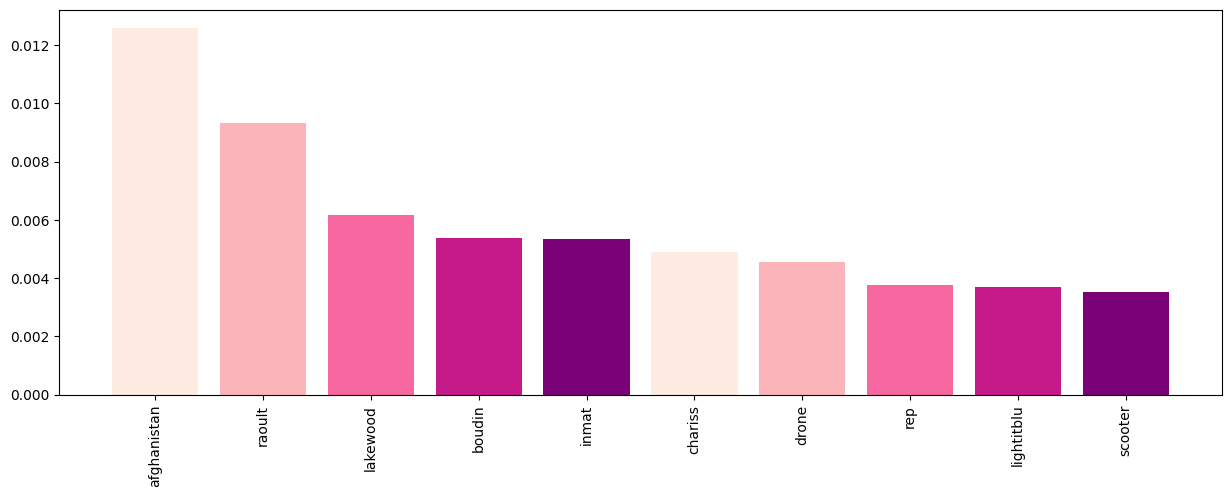

The word with a highest TF-IDF score is: afghanistan


In [58]:
colors = ['#feebe2', '#fbb4b9', '#f768a1', '#c51b8a', '#7a0177']

tfidf_ = []
for i in tf_idf_allt:
    dict_ = dict(sorted(i.items(), key=lambda item:item[1], reverse=True))
    dict_ = dict(list(dict_.items())[0: 1]) 
    tfidf_.append(dict_)  
x_data = []
y_data = []
for i in tfidf_:
    for j in i.keys():
        x_data.append(j)
        y_data.append(i.get(j))

dict_ = {}
for i in tfidf_:
    for j in i.items():
        dict_[j[0]] = j[1]
sum = 0
for i in dict_:
    sum+=dict_.get(i)
norm_dict = {}
for i in dict_:
    norm_dict[i]=dict_.get(i)/sum
    
norm_dict = dict(sorted(norm_dict.items(), key=lambda item:item[1], reverse=True))
norm_dict = dict(list(norm_dict.items())[0: 10])
fig, ax = plt.subplots(figsize=(15, 5))
plt.bar(norm_dict.keys(), norm_dict.values(), color=colors)
plt.xticks(rotation=90)
plt.show()

for i in tfidf_:
    for j in i.keys():
        if i.get(j)==max(y_data):
            e = j
print("The word with a highest TF-IDF score is:", e)

## Comparing models

In [59]:
ac_scores = []
cols = ['Logistic Regression', 'Gaussian Naive Bayes', 'Random Forest Classifier']
ac_scores.append(accuracy_score(pred, y_test)*100)

gnb = GaussianNB()
pred = gnb.fit(X_train, y_train).predict(X_test)
nb_a = accuracy_score(pred, y_test)*100
ac_scores.append(nb_a)

clf = RandomForestClassifier(max_depth = 10, random_state=0)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
rfc_a = accuracy_score(pred, y_test)*100
ac_scores.append(rfc_a)

In [60]:
vectorizer = TfidfVectorizer()

X = []
for each in df['alltext']:
    X.append(' '.join(each))
X = vectorizer.fit_transform(X)
X = X.toarray()
y = df['reliability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [61]:
clf_ = LogisticRegression(random_state = 0)
clf_.fit(X_train, y_train)
pred = clf_.predict(X_test)

print("Accuracy: %.2f%%" % (accuracy_score(pred, y_test)*100))

Accuracy: 82.43%


In [62]:
ac_scores_ = []
ac_scores_.append(accuracy_score(pred, y_test)*100)

gnb = GaussianNB()
pred = gnb.fit(X_train, y_train).predict(X_test)
nb_a = accuracy_score(pred, y_test)*100
ac_scores_.append(nb_a)

clf = RandomForestClassifier(max_depth = 10, random_state=0)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
rfc_a = accuracy_score(pred, y_test)*100
ac_scores_.append(rfc_a)

In [63]:
results = pd.DataFrame()
results['Models'] = cols
results['TF-IDF from scratch'] = ac_scores
results['TF-IDF from sklearn'] = ac_scores_
results

,Models,TF-IDF from scratch,TF-IDF from sklearn
0,Logistic Regression,90.311987,82.430213
1,Gaussian Naive Bayes,81.937603,82.266010
2,Random Forest Classifier,71.592775,73.070608
